In [ ]:
#@title Install Required Packages
!pip install scanpy[leiden]
!pip install MulticoreTSNE
!pip install seaborn==0.10.0


     |████████████████████████████████| 7.7MB 3.6MB/s 
     |████████████████████████████████| 122kB 46.3MB/s 
     |████████████████████████████████| 3.2MB 44.6MB/s 
     |████████████████████████████████| 2.4MB 44.5MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
  Created wheel for sinfo: filename=sinfo-0.3.1-cp36-none-any.whl size=7018 sha256=e60f9765df05941a0ca815326e11940c3c991fb75ba0a20f3df819b4ce71011d
  Stored in directory: /root/.cache/pip/wheels/11/f0/23/347d6d8e59787c2bc272162d18223dc3b45bd6dc40aceee6af
Successfully built sinfo
  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp36-cp36m-linux_x86_64.whl size=68503 sha256=22bfd801916410c3f520f3fc11150b0beb8f1f88c9eebf0c9c11eda29b7b11e9
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE
     |████████████████████████████████| 225kB 6.1MB/s 
  Found existing inst

In [ ]:
#@title Mount Google Drive (You don't need to run this if you are running notebooks on your laptop)

from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")

Mounted at /content/drive


Data analysis on Clonal kinetics and single-cell transcriptional profiling of CAR-T cells in patients undergoing CD19 CAR-T immunotherapy https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6954177/



In [ ]:
import scanpy as sc
from pathlib import Path

# set scanpy plotting parameter to dpi = 150
sc.settings.set_figure_params(dpi=150)

In [ ]:
DATA = Path("/content/drive/MyDrive/Intro to Gennomic Info Sci Project")

In [ ]:
#Read the raw expression matrix into a scanpy AnnData object 
#GE is already pre-filtered for mito% >20, unique gene count < 200, UMI count > 40,000
ge = sc.read_csv(
    DATA / "GSE125881_raw.expMatrix.csv.gz"
).transpose()

In [ ]:
#converted the ge.X matrix to a sparse matrix because processing steps on the dense 
#matrix caused colab to crash
from scipy import sparse

ge.X = sparse.csr_matrix(ge.X)


Meta data is found at the following github, https://github.com/ValentinVoillet/CAR-T/blob/master/R_code.R

In [ ]:
#Add in the sample meta data as per the github code to ge.obs 
import pandas as pd
ge.obs['sample_id'] = [s.split('-')[1] for s in ge.obs_names]
ge.obs['patient'] = ge.obs.sample_id.map({'1':'CLL-1', '2':'CLL-1', '3':'CLL-1', '4':'CLL-1', '5':'NHL-6', 
                                          '6':'NHL-6', '7':'NHL-6', '8':'CLL-2', '9':'CLL-2', '10':'CLL-2', 
                                          '11':'CLL-2', '12':'NHL-7', '13':'NHL-7', '14':'NHL-7', '15':'NHL-7', 
                                          '16':'NHL-6'}
                                         )
ge.obs['time_point'] = ge.obs.sample_id.map({'1':'IP', '2':'d21', '3':'d38', '4':'d112', '5':'d12', 
                                          '6':'d29', '7':'d102', '8':'IP', '9':'d12', '10':'d29', 
                                          '11':'d83', '12':'IP', '13':'d12', '14':'d28', '15':'d89', 
                                          '16':'IP'}
                                         )
ge.obs['group'] = ge.obs.sample_id.map({'1':'IP', '2':'Early', '3':'Late', '4':'Very Late', '5':'Early', 
                                          '6':'Late', '7':'Very Late', '8':'IP', '9':'Early', '10':'Late', 
                                          '11':'Very Late', '12':'IP', '13':'Early', '14':'Late', '15':'Very Late', 
                                          '16':'IP'}
                                       )
ge.obs['patient_point'] = ge.obs.sample_id.map({'1':'CLL-1_IP', '2':'CLL-1_Early', '3':'CLL-1_Late', '4':'CLL-1_Very Late', '5':'NHL-6_Early', 
                                          '6':'NHL-6_Late', '7':'NHL-6_Very Late', '8':'CLL-2_IP', '9':'CLL-2_Early', '10':'CLL-2_Late', 
                                          '11':'CLL-2_Very Late', '12':'NHL-7_IP', '13':'NHL-7_Early', '14':'NHL-7_Late', '15':'NHL-7_Very Late', 
                                          '16':'NHL-6_IP'})
ge.obs['disease'] = [s.split('-')[0] for s in ge.obs.patient]
ge.obs

sample_id patient time_point group patient_point disease
AAACCTGAGCGTCTAT-1          1   CLL-1         IP    IP      CLL-1_IP     CLL
AAACCTGCAATAGAGT-1          1   CLL-1         IP    IP      CLL-1_IP     CLL
AAACCTGCATGACGGA-1          1   CLL-1         IP    IP      CLL-1_IP     CLL
AAACCTGGTAGTGAAT-1          1   CLL-1         IP    IP      CLL-1_IP     CLL
AAACCTGGTCTCCCTA-1          1   CLL-1         IP    IP      CLL-1_IP     CLL
...                       ...     ...        ...   ...           ...     ...
TTGGAACTCGACAGCC-16        16   NHL-6         IP    IP      NHL-6_IP     NHL
TTGTAGGAGTTAGGTA-16        16   NHL-6         IP    IP      NHL-6_IP     NHL
TTTACTGAGACCACGA-16        16   NHL-6         IP    IP      NHL-6_IP     NHL
TTTATGCCAATGAAAC-16        16   NHL-6         IP    IP      NHL-6_IP     NHL
TTTGGTTGTACAAGTA-16        16   NHL-6         IP    IP      NHL-6_IP     NHL

[62167 rows x 6 columns]

In [ ]:
#add percent mito to ge.obs
import numpy as np 
mito_genes = ge.var_names.str.startswith('MT-')
ge.obs['percent_mito'] = np.sum(ge[:, mito_genes].X, axis=1) / np.sum(ge.X, axis=1)
ge.obs

sample_id patient  ... disease percent_mito
AAACCTGAGCGTCTAT-1          1   CLL-1  ...     CLL     0.037927
AAACCTGCAATAGAGT-1          1   CLL-1  ...     CLL     0.084149
AAACCTGCATGACGGA-1          1   CLL-1  ...     CLL     0.049491
AAACCTGGTAGTGAAT-1          1   CLL-1  ...     CLL     0.064682
AAACCTGGTCTCCCTA-1          1   CLL-1  ...     CLL     0.049556
...                       ...     ...  ...     ...          ...
TTGGAACTCGACAGCC-16        16   NHL-6  ...     NHL     0.002561
TTGTAGGAGTTAGGTA-16        16   NHL-6  ...     NHL     0.132093
TTTACTGAGACCACGA-16        16   NHL-6  ...     NHL     0.057638
TTTATGCCAATGAAAC-16        16   NHL-6  ...     NHL     0.160506
TTTGGTTGTACAAGTA-16        16   NHL-6  ...     NHL     0.044797

[62167 rows x 7 columns]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
... storing 'sample_id' as categorical
... storing 'patient' as categorical
... storing 'time_point' as categorical
... storing 'group' as categorical
... storing 'patient_point' as categorical
... storing 'disease' as categorical


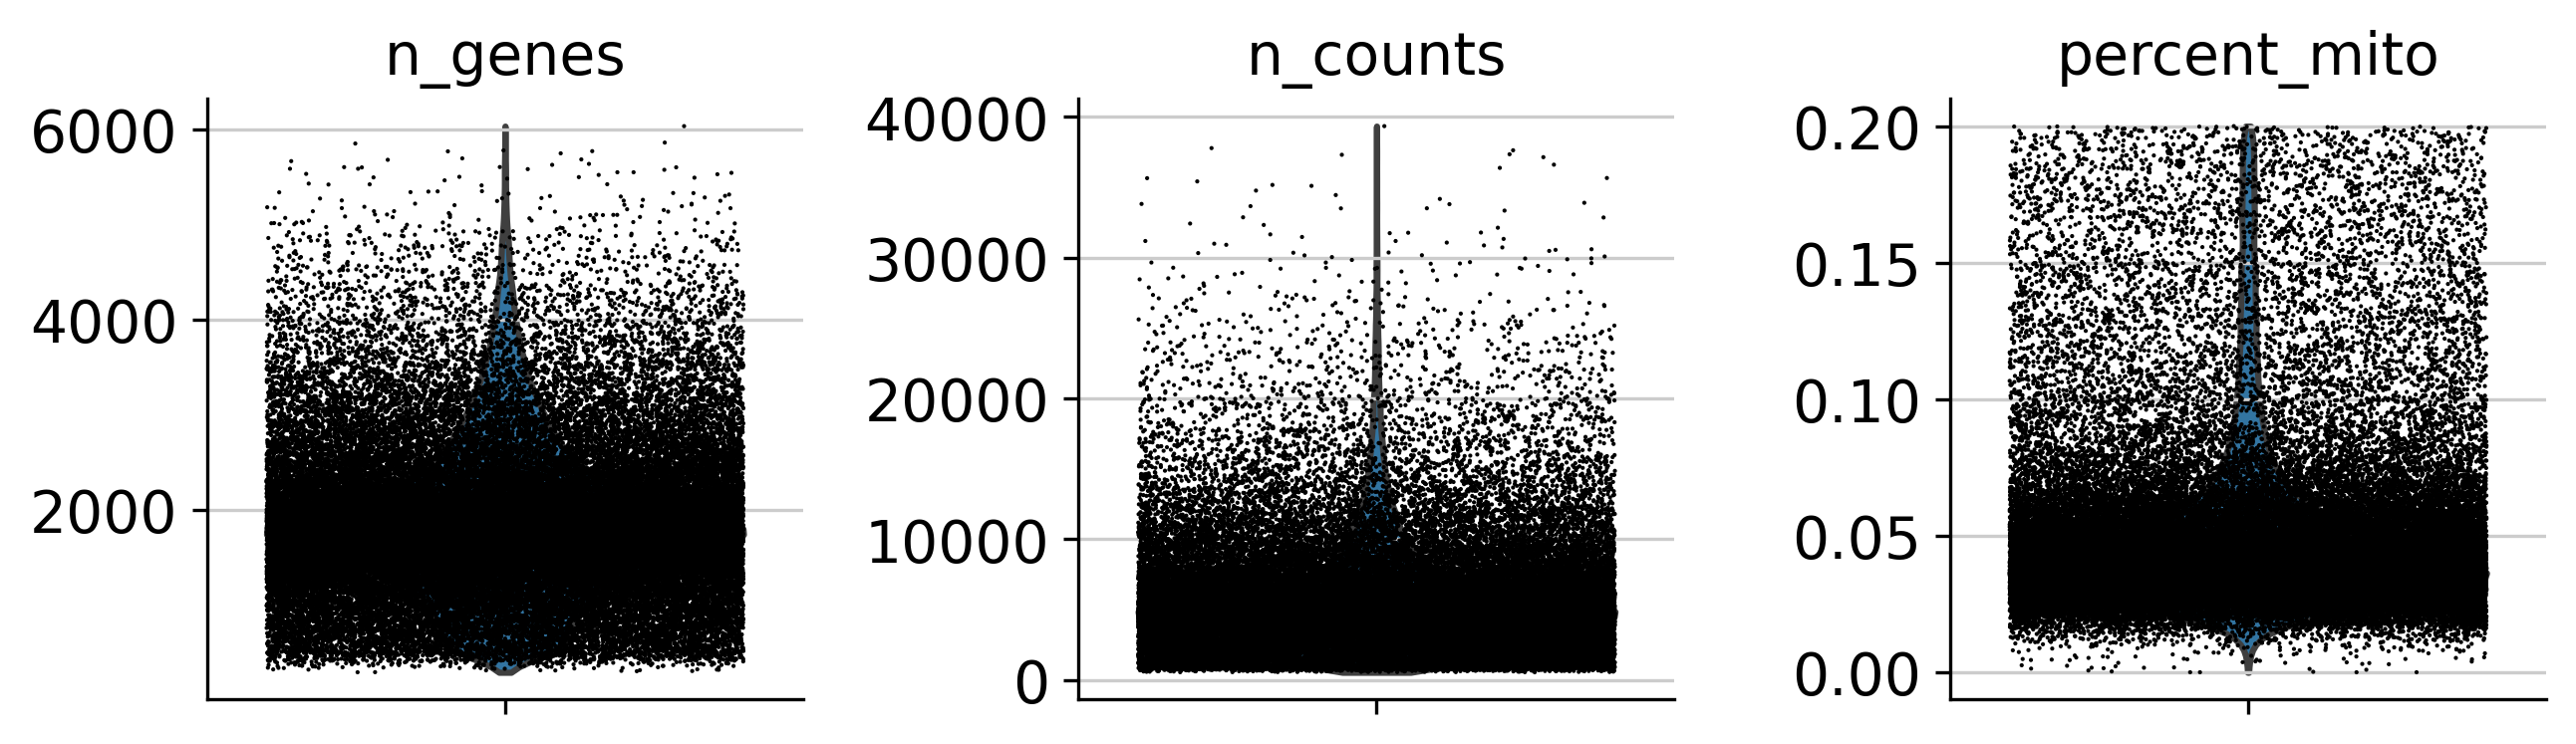

In [ ]:
import numpy as np

#Visualize the data via violin plots to determine the filtering that has already been performed
#You can see that Mito genes have all been removed, and counts have been filter to between ~500 - 10k
#genes have been filter to ~200 - 4k

sc.pp.filter_cells(ge, min_genes=0)
sc.pp.filter_genes(ge, min_cells=0)

mito_genes = ge.var_names.str.startswith('MT-')

ge.obs['percent_mito'] = np.sum(ge[:, mito_genes].X, axis=1) / np.sum(ge.X, axis=1)
r = np.sum(ge[:,mito_genes].X, axis=1)
p = np.sum(ge.X, axis=1)
ge.obs['n_counts'] = np.ravel(ge.X.sum(axis=1))

sc.pl.violin(ge, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=.4, multi_panel=True)

In [ ]:
#normalize with CP10K to normalize all counts to 10K per cell
sc.pp.normalize_per_cell(ge, counts_per_cell_after=1e4)
#log trasnform the normalized counts 
sc.pp.log1p(ge)

In [ ]:
#Find highly variable genes
sc.pp.highly_variable_genes(ge,min_mean=0.0125, max_mean=4, min_disp=0.5, flavor='seurat')

In [ ]:
#Save the normalized data in the ge.raw for later modeling
ge.raw = ge

In [ ]:
#Filter to only include the highly_variable genes
ge = ge[:, ge.var['highly_variable']]

In [ ]:
#Regress out library effect size and percent mito
sc.pp.regress_out(ge, keys=['n_counts','percent_mito'])

In [ ]:
#scale data to univariate
sc.pp.scale(ge, max_value=10)

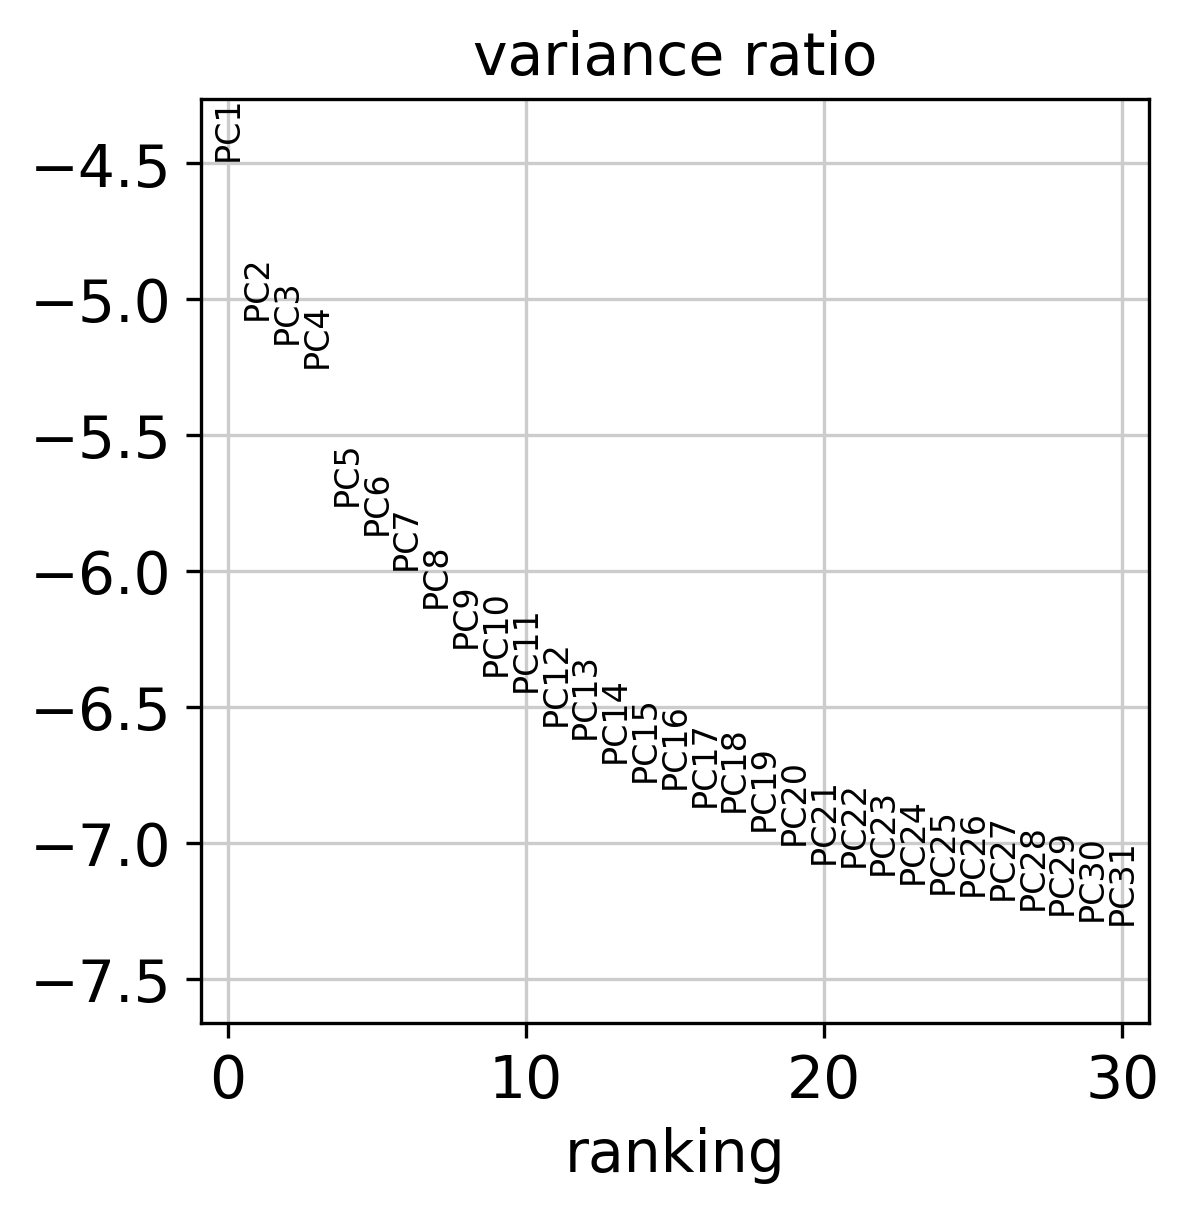

In [ ]:
#Perform PCA on top highly variable genes and plot PCs 
sc.tl.pca(ge, svd_solver='arpack')
sc.pl.pca_variance_ratio(ge, log=True)

In [ ]:
#Find nearest neighbors using the closest 10 neighbors (default Seurat value as described in the Scanpy tutorial) and top 15 PCs
sc.pp.neighbors(ge, n_neighbors=10, n_pcs=15)

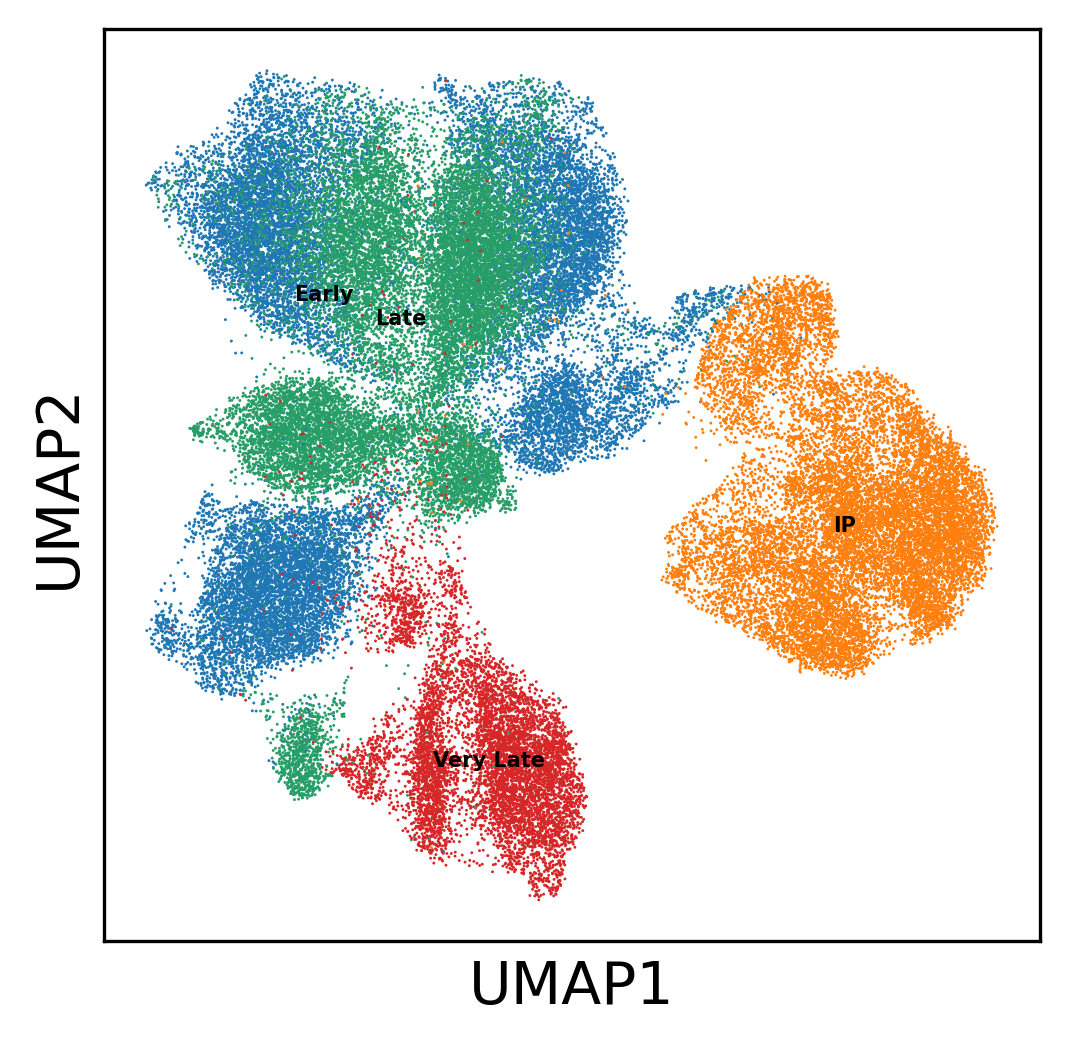

In [ ]:
#Perform UMAP on the nearest neighbors
#plot the UMAP with group as color
#use raw = FALSE to use the corrected data (regressed out and scaled)
sc.tl.umap(ge)
sc.settings.set_figure_params(dpi=150)
sc.pl.umap(ge, color=["group"], legend_loc='on data', legend_fontsize=5, use_raw=False, title='')

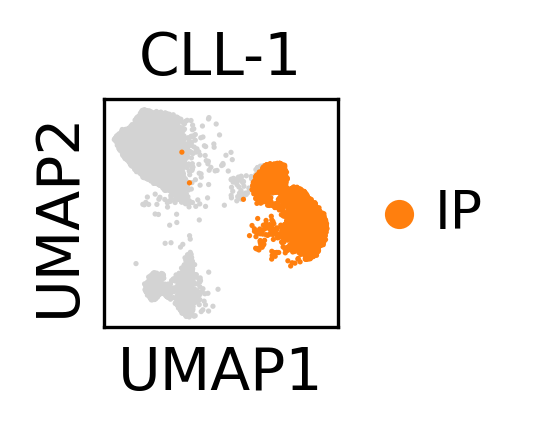

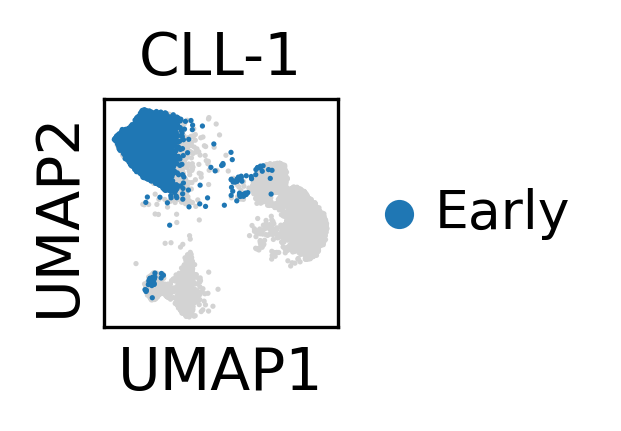

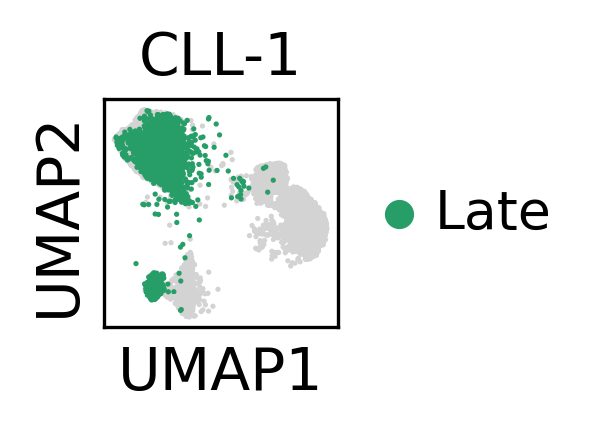

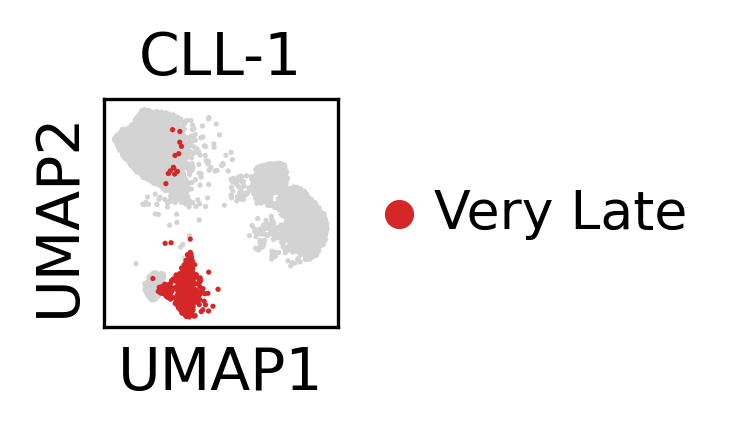

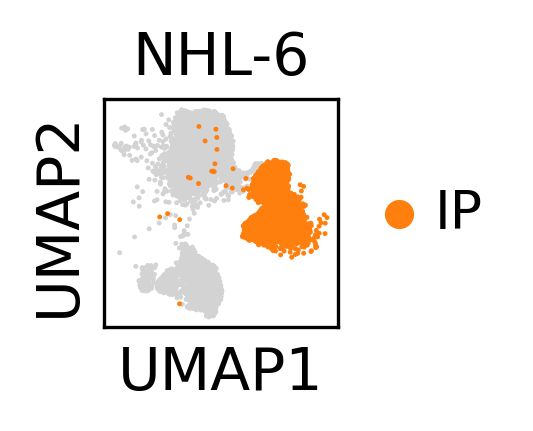

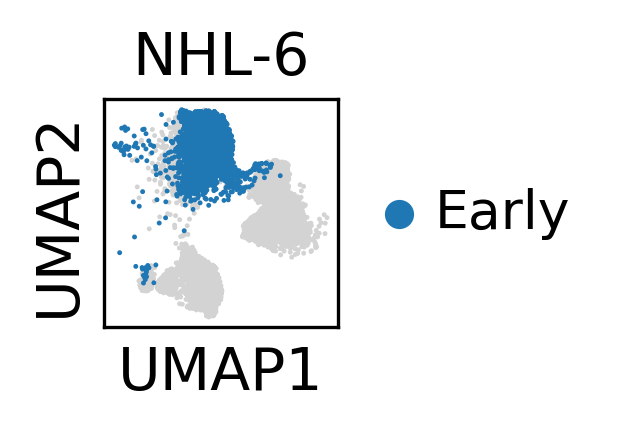

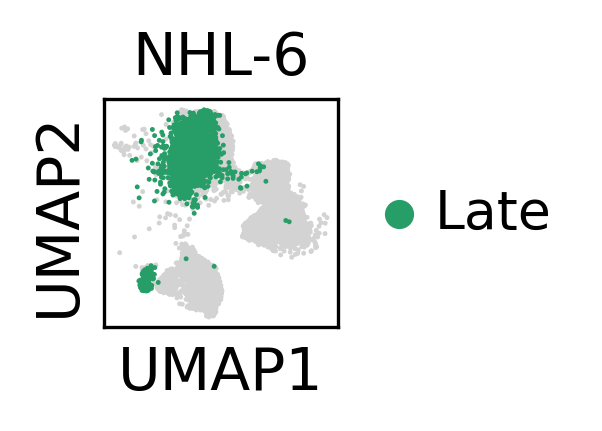

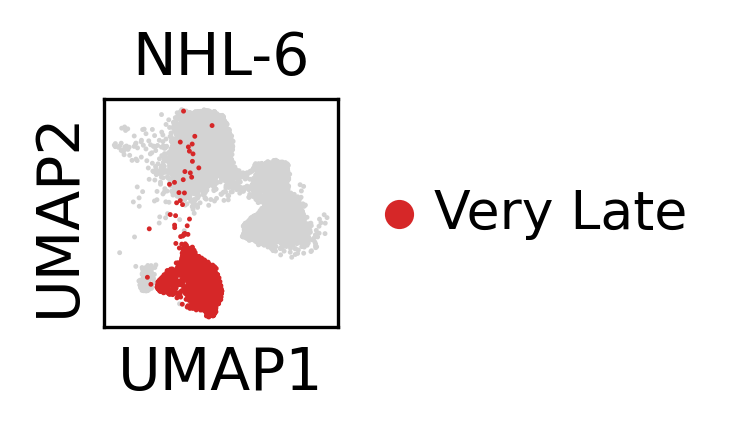

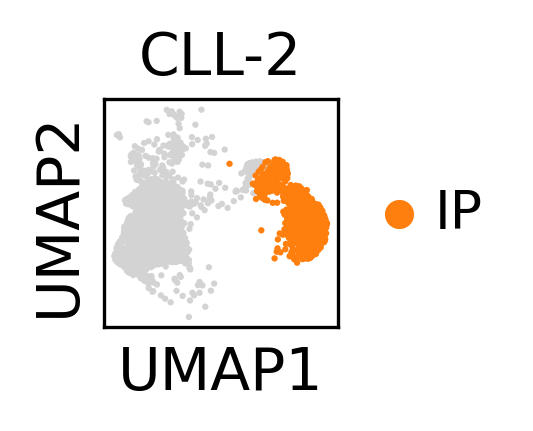

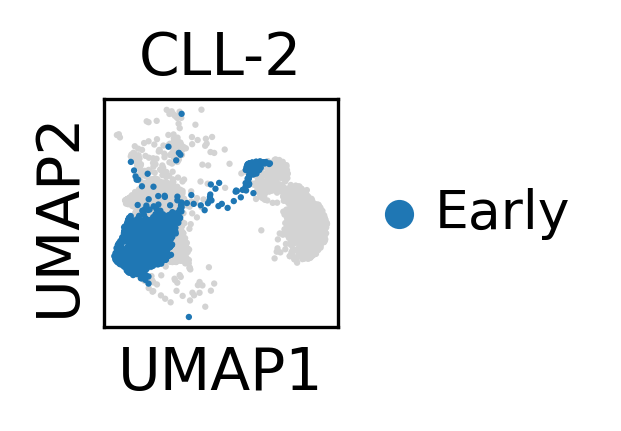

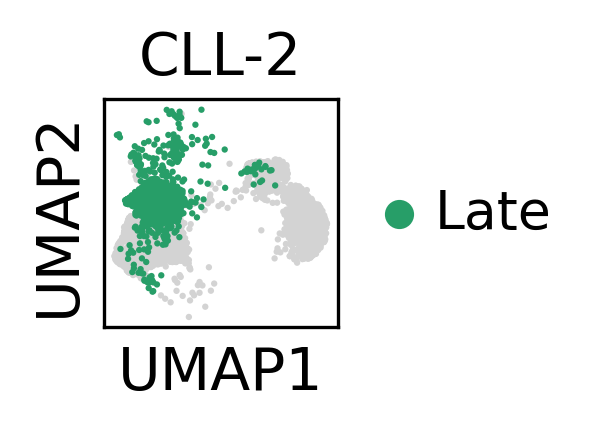

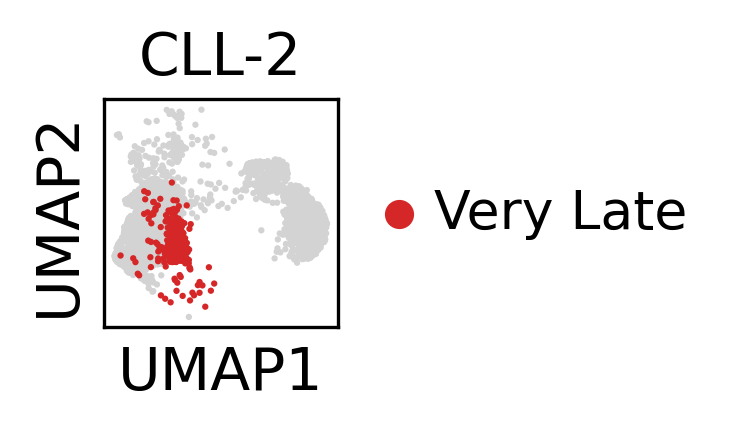

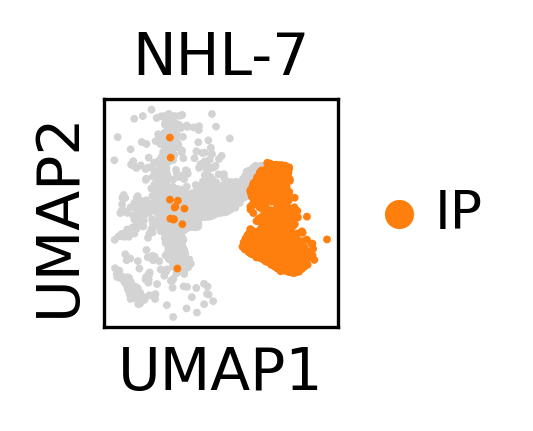

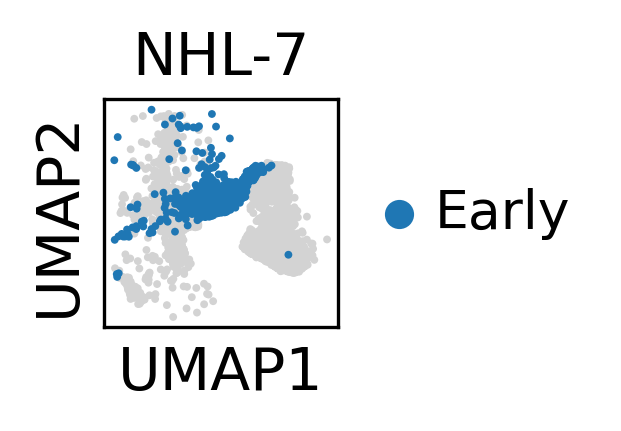

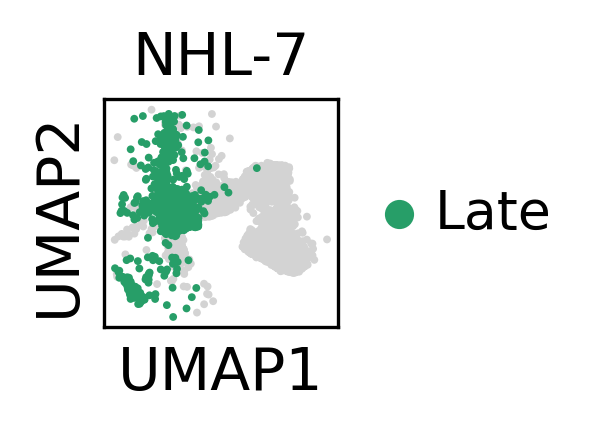

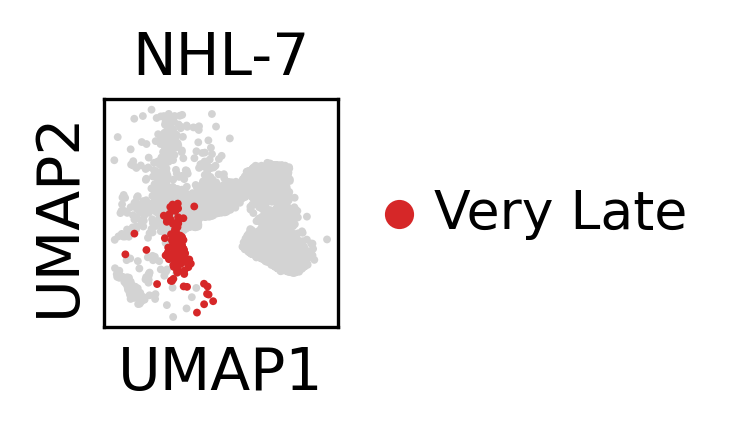

In [ ]:
#Plot UMAP for each patient and each time point
sc.settings.set_figure_params(dpi=150, figsize=(1, 1))

for x in ge.obs.patient.unique():
  for y in ge.obs.group.unique():
    sc.pl.umap(ge[(ge.obs.patient == x)], color=['group'], groups=y, title=x, use_raw=False)

In [ ]:
#Rank the genes via t-test comparing gene expression between patient_point groups
#create a dataframe with the top ranked genes for each patient_point
sc.tl.rank_genes_groups(ge, groupby=('patient_point'), method='t-test', use_raw=True)
top_rank_genes = pd.DataFrame(ge.uns['rank_genes_groups']['names'])
top_rank_genes.head(50)

CLL-1_Early CLL-1_IP CLL-1_Late  ... NHL-7_IP NHL-7_Late NHL-7_Very Late
0        RPS26     ENO1     MALAT1  ...    GAPDH    MT-ATP6           RPL41
1         NKG7     TPI1  MTRNR2L12  ...     TPI1     MALAT1            EIF1
2         GZMK    GAPDH    MT-ATP6  ...      MIF       GZMH          RPL36A
3         CMC1      MIF     MT-ND3  ...     ENO1       GNLY           RPL26
4         CD27      PKM       CMC1  ...     LDHA     IFITM3           H3F3B
5         PRF1     LDHA      DUSP2  ...    ALDOA     MT-ND4          MT-ND4
6         CST7      LTB      RPS26  ...     IL32       FLNA           RPS27
7         CD74      GPI       DDX5  ...    RPLP0      KLRG1           RPS29
8          MX1    ALDOA     MT-ND5  ...      GPI     MT-CYB           HLA-B
9         IFI6     PGK1     MT-CO1  ...      VIM     FCGR3A           RPS21
10       ISG15     IL32      KLRC1  ...    TIMP1     ADGRG1         MT-ATP6
11      RPS4Y1     IER2    MT-ATP8  ...      PKM    MT-ATP8          MALAT1
12     PTPRCAP    RPLP0      ASCL2  ...   SLC2A3     MT-ND3          PMAIP1
13        XAF1      JUN       PLS3  ...     RPL8       XIST          NFKBIA
14       HLA-B     RPS5       LYST  ...  S100A11      RPL26           RPL34
15       ISG20      VIM      IKZF3  ...      FOS    MT-ND4L           RPS4X
16      IFITM1    PGAM1     RPL36A  ...     RPS5      HLA-B          RPL37A
17       DUSP2  SLC16A3     RNF213  ...     PGK1      S1PR5           RPS26
18        CCL5   TAGLN2      P2RY8  ...    FXYD5   HLA-DQA2         TNFAIP3
19        LY6E   RPS4Y1     MT-ND4  ...    RPS4X      TXNIP          RPS15A
20        LAG3     RPL8      DDX17  ...   MT-ND4       KLF2          RPS27A
21    APOBEC3G      AK4     MT-ND6  ...    ACTG1     MT-ND5            SBDS
22      TRIM22   C4orf3     FAM65B  ...      JUN     RPL36A           RPL12
23       NR4A2   TMSB4X      CADM1  ...  S100A10       SRRT          MT-ND3
24        GNLY     NCR3     TRIM22  ...   C4orf3     MT-CO1         TSC22D3
25       HLA-C     CISH       PLEC  ...     LDHB      HLA-C           PNRC1
26        CTSW  S100A10      SYNE2  ...   TAGLN2     TGFBR3           RPL39
27        CNN2     RBPJ      SYNE1  ...    RPL18       NKG7           CXCR4
28       LITAF    CXCR3      ARL4C  ...     RPS8     MT-ND2          MT-CYB
29       ARL4C    ACTG1     RALGDS  ...     IER2   HLA-DRB1          IFITM3
30       PSMB9    TIMP1        UTY  ...    GSTK1      RPS27           RPL21
31        IRF7     RPS2     MT-ND2  ...  ALOX5AP   HLA-DRB5          EEF1A1
32       SP100     LDHB      MCTP2  ...   GNB2L1       ZEB2           RPL13
33       HLA-A    LRRN3     KANSL1  ...   IFITM3       DDX5            RPS7
34        CCL4    EGLN3        FGR  ...    PGAM1   HLA-DPA1           HLA-C
35     EIF2AK2     HOPX       FLNA  ...     EGR1      CEP78           RPS14
36        BST2    ATP5D    N4BP2L2  ...    RPS18      RPS29            RPL3
37        MT2A     PIM1      VAMP2  ...     TPM4       CCL5           RBM39
38      UBE2L6     LSP1       AKNA  ...    EGLN3       PLEK            RPS2
39      CORO1A  TMEM123  ITGB2-AS1  ...     CD69     PRSS23            EPC1
40      SHISA5    RPS3A    ZFP36L2  ...  SLC16A3        CD6           RPS28
41        PLS3   IFITM2      DIP2A  ...      AK4      TTC38          DNAJB6
42      EPSTI1    COTL1     HAVCR2  ...    RPL29      PRKCB          TUBB2A
43     RPL36AL    P4HA1    PPP2R5C  ...     PIM2     FGFBP2         ZFAND2A
44      CHI3L2     DARS       DGKZ  ...    GATA3       GZMB           PELI1
45      LGALS9   BNIP3L       CCL4  ...   TMSB4X   TRBV20-1           RPL11
46       STAT1     CD96      EOMES  ...     GBP2  MTRNR2L12           NR4A2
47        CD3D     SIT1   ARHGAP10  ...     RBPJ       LIM2            OASL
48      SAMD9L     NPM1     RPS4Y1  ...    SERP1      ITGB2           RPL37
49     ZFP36L2    RPS18       CBLB  ...    DDIT4      CIRBP            RPS3

[50 rows x 16 columns]

In [ ]:
#Copy the top 200 genes from top_rank genes into a new dataframe
#only keep those genes that have logFC > 1.0
top_gene_lfc = top_rank_genes.head(200).copy()

for x in top_gene_lfc.columns:
  for y in top_gene_lfc.index:
    if ge.uns['rank_genes_groups']['logfoldchanges'][y][x] < 1:
      top_gene_lfc[x][y] = 'nan'

top_gene_lfc

CLL-1_Early CLL-1_IP CLL-1_Late  ...       NHL-7_IP NHL-7_Late NHL-7_Very Late
0         RPS26     ENO1     MALAT1  ...          GAPDH        nan           RPL41
1          NKG7     TPI1  MTRNR2L12  ...           TPI1        nan            EIF1
2          GZMK    GAPDH        nan  ...            MIF       GZMH          RPL36A
3          CMC1      MIF        nan  ...           ENO1        nan           RPL26
4          CD27      PKM       CMC1  ...           LDHA     IFITM3           H3F3B
..          ...      ...        ...  ...            ...        ...             ...
195         nan      nan        nan  ...           ASB2        nan             nan
196         nan    ITM2C        nan  ...          P4HA2        nan           IFIT1
197         nan      nan    PACSIN1  ...          SHMT2        nan            NME4
198         nan      nan        nan  ...  CH17-373J23.1        nan           DDIT3
199    RASGEF1A      nan       PON2  ...          POLD4        nan          NUDT15

[200 rows x 16 columns]

In [ ]:
#From the genes in top_gene_lfc only keep those genes that are differentially 
#expressed across all patients within a specific timepoint
heat_genes = []

for x in top_gene_lfc['CLL-1_IP']:
  if (top_gene_lfc['CLL-2_IP'].str.contains(x)).sum()+(top_gene_lfc['NHL-6_IP'].str.contains(x)).sum()+(top_gene_lfc['NHL-7_IP'].str.contains(x)).sum() == 3:
    heat_genes.append(x)
for x in top_gene_lfc['CLL-1_Early']:
  if (top_gene_lfc['CLL-2_Early'].str.contains(x)).sum()+(top_gene_lfc['NHL-6_Early'].str.contains(x)).sum()+(top_gene_lfc['NHL-7_Early'].str.contains(x)).sum() == 3:
    heat_genes.append(x)
for x in top_gene_lfc['CLL-1_Late']:
  if (top_gene_lfc['CLL-2_Late'].str.contains(x)).sum()+(top_gene_lfc['NHL-6_Late'].str.contains(x)).sum()+(top_gene_lfc['NHL-7_Late'].str.contains(x)).sum() == 3:
    heat_genes.append(x)
for x in top_gene_lfc['CLL-1_Very Late']:
  if (top_gene_lfc['CLL-2_Very Late'].str.contains(x)).sum()+(top_gene_lfc['NHL-6_Very Late'].str.contains(x)).sum()+(top_gene_lfc['NHL-7_Very Late'].str.contains(x)).sum() == 3:
    heat_genes.append(x)

heat_genes
   

['ENO1',
 'TPI1',
 'GAPDH',
 'MIF',
 'PKM',
 'LDHA',
 'GPI',
 'ALDOA',
 'PGK1',
 'IL32',
 'IER2',
 'VIM',
 'PGAM1',
 'SLC16A3',
 'TAGLN2',
 'AK4',
 'C4orf3',
 'CISH',
 'RBPJ',
 'TIMP1',
 'EGLN3',
 'ATP5D',
 'PIM1',
 'TMEM123',
 'COTL1',
 'P4HA1',
 'DARS',
 'BNIP3L',
 'SIT1',
 'FAM162A',
 'CD69',
 'EGR1',
 'CAPG',
 'FOS',
 'SLC2A3',
 'IMPDH2',
 'ABRACL',
 'PRDX2',
 'DDIT4',
 'ANP32B',
 'TMEM14C',
 'HSPD1',
 'KDELR1',
 'VDAC1',
 'ALDOC',
 'ALOX5AP',
 'H2AFZ',
 'IL2RA',
 'DYNLL1',
 'RP11-160E2.6',
 'PAICS',
 'NDUFB5',
 'GPX1',
 'PPA1',
 'GZMK',
 'RPL36A',
 'CXCR4',
 'WHAMM']

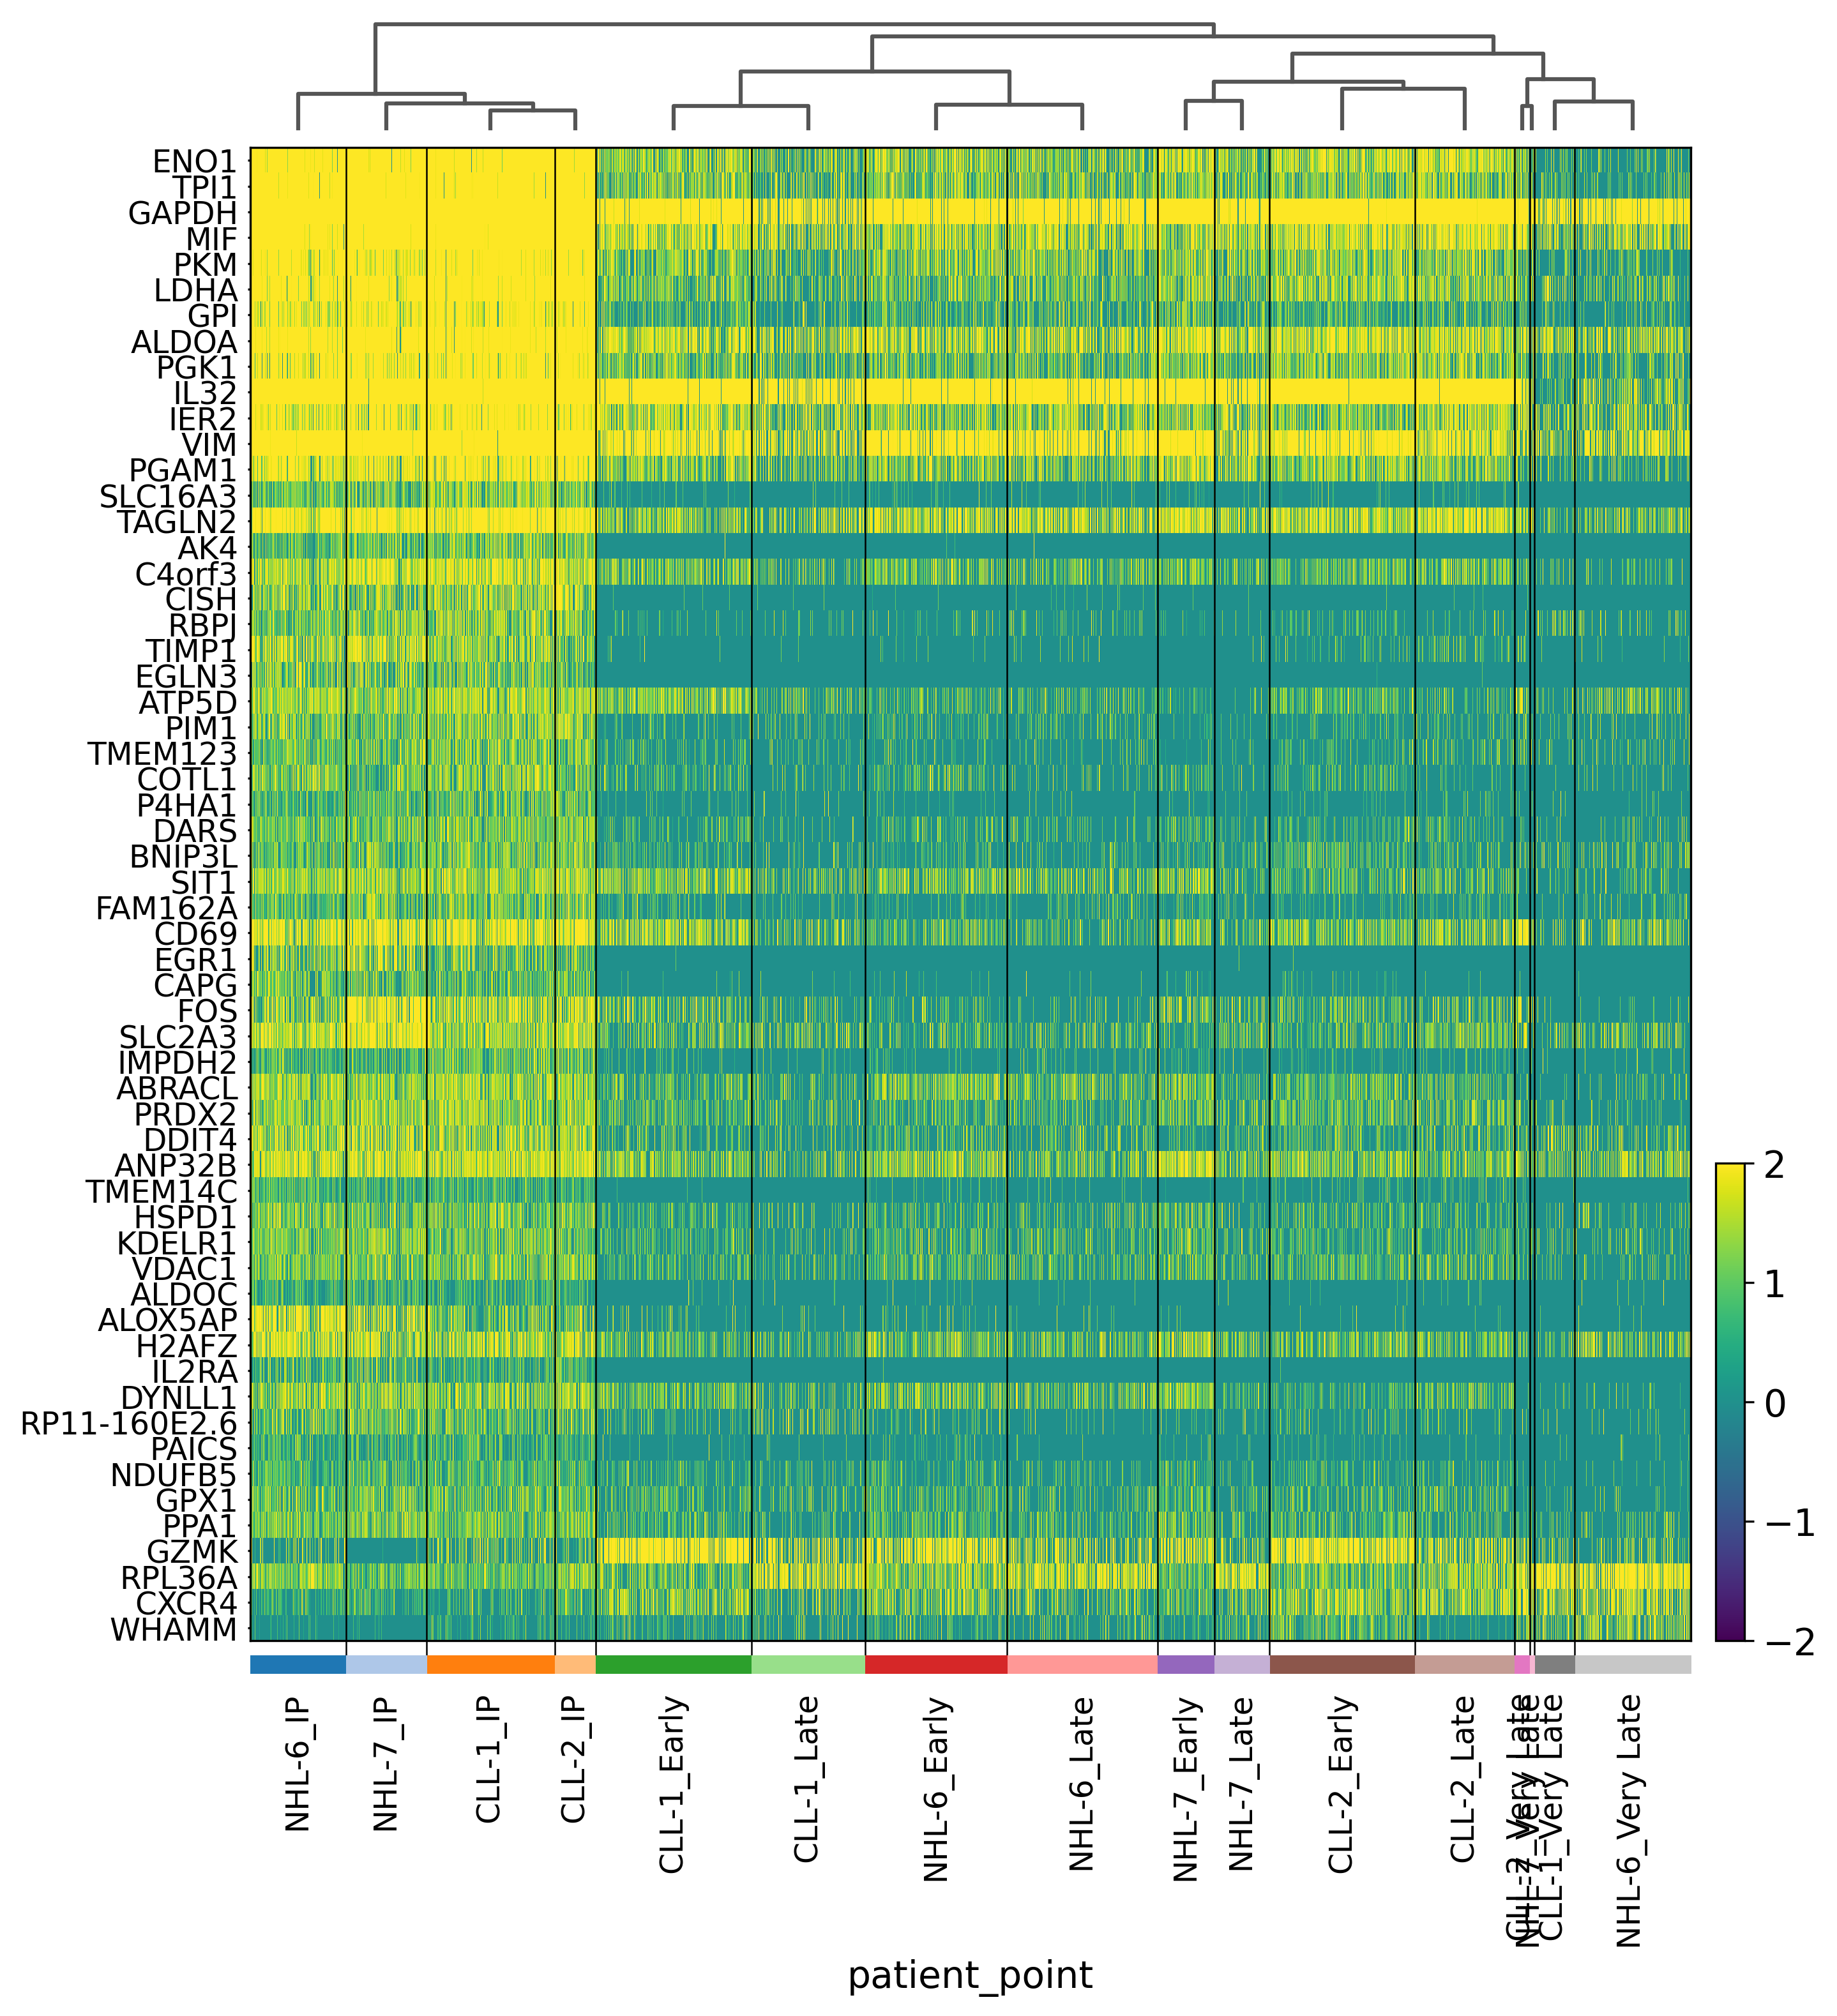

In [ ]:
#Plot the expression values of the genes in heat_genes as a heatmap
sc.pl.heatmap(ge, groupby='patient_point', var_names=heat_genes, swap_axes=True, 
              vmin =-2, vmax=2, dendrogram=True, use_raw=True, show_gene_labels=True
              )

In [ ]:
#for panel c
#All gene sets were saved in text files. 
GSEA_BTM_file = DATA / 'GSEA/geneset_BTM_T_ACT.txt'
GSEA_KEGG_OX_file = DATA / 'GSEA/geneset_KEGG_oxphos.txt'
GSEA_KEGG_tca_file = DATA / 'GSEA/geneset_KEGG_CAC_TCA.txt'
GSEA_Tem_file = DATA / 'GSEA/geneset_tem_eff.txt'
GSEA_Ex_W_file = DATA / 'GSEA/geneset_exhaust_wherry.txt'
GSEA_Ex_L_file = DATA / 'GSEA/geneset_exhaust_long.txt'

#read the gene set into a pd DataFrame, separtor is new line, comment is >, and then remove blank spaces in gene names
gsea_btm= pd.read_csv(GSEA_BTM_file, sep='\n', comment='>')
gsea_btm = gsea_btm['BTM - T cell Activation (II)'].str.replace(' ','')
gsea_kegg_ox = pd.read_csv(GSEA_KEGG_OX_file, sep='\n', comment='>')
gsea_kegg_ox = gsea_kegg_ox['KEGG_OXIDATIVE_PHOSPHORYLATION'].str.replace(' ','')
gsea_kegg_tca = pd.read_csv(GSEA_KEGG_tca_file, sep='\n', comment='>')
gsea_kegg_tca = gsea_kegg_tca['KEGG_CITRATE_CYCLE_TCA_CYCLE'].str.replace(' ','')
gsea_tem = pd.read_csv(GSEA_Tem_file , sep='\n', comment='>')
gsea_tem = gsea_tem['Tem/eff'].str.replace(' ','')
gsea_t_ex_w = pd.read_csv(GSEA_Ex_W_file, sep='\n', comment='>')
gsea_t_ex_w = gsea_t_ex_w['Exhaustion Wherry '].str.replace(' ','')
gsea_t_ex_l = pd.read_csv(GSEA_Ex_L_file, sep='\n', comment='>')
gsea_t_ex_l = gsea_t_ex_l['Exhaustion Long'].str.replace(' ','')

In [ ]:
#Only keep the time points after IP for each sample
pat_tim_point = pd.DataFrame(top_rank_genes.columns)
pat_tim_point.columns = ['patient_point']
pat_tim_point = pat_tim_point[~pat_tim_point['patient_point'].str.contains('IP')]
#create a list of all the gsea gene sets
gsea = [gsea_btm, gsea_kegg_ox, gsea_kegg_tca, gsea_tem, gsea_t_ex_w, gsea_t_ex_l]

#Function to find the t-score of each gene in each patient time point
#first identify the index of the gene in the top genes dataframe within the patient timepoint
#use the indices and the patient time point name to find the average t-score of that patient for the specific gene set
def combined_t (patient, pat_tim_point, top_rank_genes, gsea, ge):
  top_genes_gsea_idx = top_rank_genes[top_rank_genes[patient].isin(gsea)].index
  t_score = np.average(ge.uns['rank_genes_groups']['scores'][patient][top_genes_gsea_idx])
  return (t_score) 

In [ ]:
#create an empty dataframe for the tscore results storing patient, group, gsea gene set, and combined tscore
data = pd.DataFrame(np.zeros((len(pat_tim_point)*len(gsea), 4)))
data.columns = ['patient', 'group', 'gsea', 'tscore']

#calculate the combined z-score for each group.
n=0
for  y in gsea:
  for x in list(pat_tim_point.patient_point):
    t_sc = combined_t(x, pat_tim_point, top_rank_genes, y, ge)
    data.loc[n, 'patient'] = x[:5]
    data.loc[n, 'group'] = x[6:]
    data.loc[n, 'gsea'] = y.name
    data.loc[n,'tscore'] = t_sc
    n+=1
data 

patient      group                          gsea     tscore
0    CLL-1      Early  BTM - T cell Activation (II)  14.476494
1    CLL-1       Late  BTM - T cell Activation (II) -11.672441
2    CLL-1  Very Late  BTM - T cell Activation (II) -27.195028
3    CLL-2      Early  BTM - T cell Activation (II)  -0.308396
4    CLL-2       Late  BTM - T cell Activation (II)   1.038606
..     ...        ...                           ...        ...
67   NHL-6       Late               Exhaustion Long  -8.829142
68   NHL-6  Very Late               Exhaustion Long -14.653954
69   NHL-7      Early               Exhaustion Long  -7.451477
70   NHL-7       Late               Exhaustion Long  -9.890577
71   NHL-7  Very Late               Exhaustion Long  -7.682333

[72 rows x 4 columns]

In [ ]:
#create a groupby object with the average values grouped by time point in each gsea set
group = data.groupby(['gsea', 'group']).mean()

#add these average values to the data Dataframe as the average values at each time point within each gsea set
for x in group.index:
  data = data.append({'patient':'average', 'group':x[1], 'gsea':x[0], 'tscore':group.loc[x][0]}, ignore_index=True)
data

tscore
gsea                           group               
BTM - T cell Activation (II)   Early       9.574042
                               Late       -3.398662
                               Very Late -18.332680
Exhaustion Long                Early      -7.311808
                               Late       -9.305794
                               Very Late -10.742042
Exhaustion Wherry              Early       1.313041
                               Late       -5.120785
                               Very Late  -9.633513
KEGG_CITRATE_CYCLE_TCA_CYCLE   Early       3.174141
                               Late       -6.105985
                               Very Late  -9.906367
KEGG_OXIDATIVE_PHOSPHORYLATION Early       3.922224
                               Late       -3.120403
                               Very Late  -7.825266
Tem/eff                        Early      10.496796
                               Late        2.179803
                               Very Late -19.439433

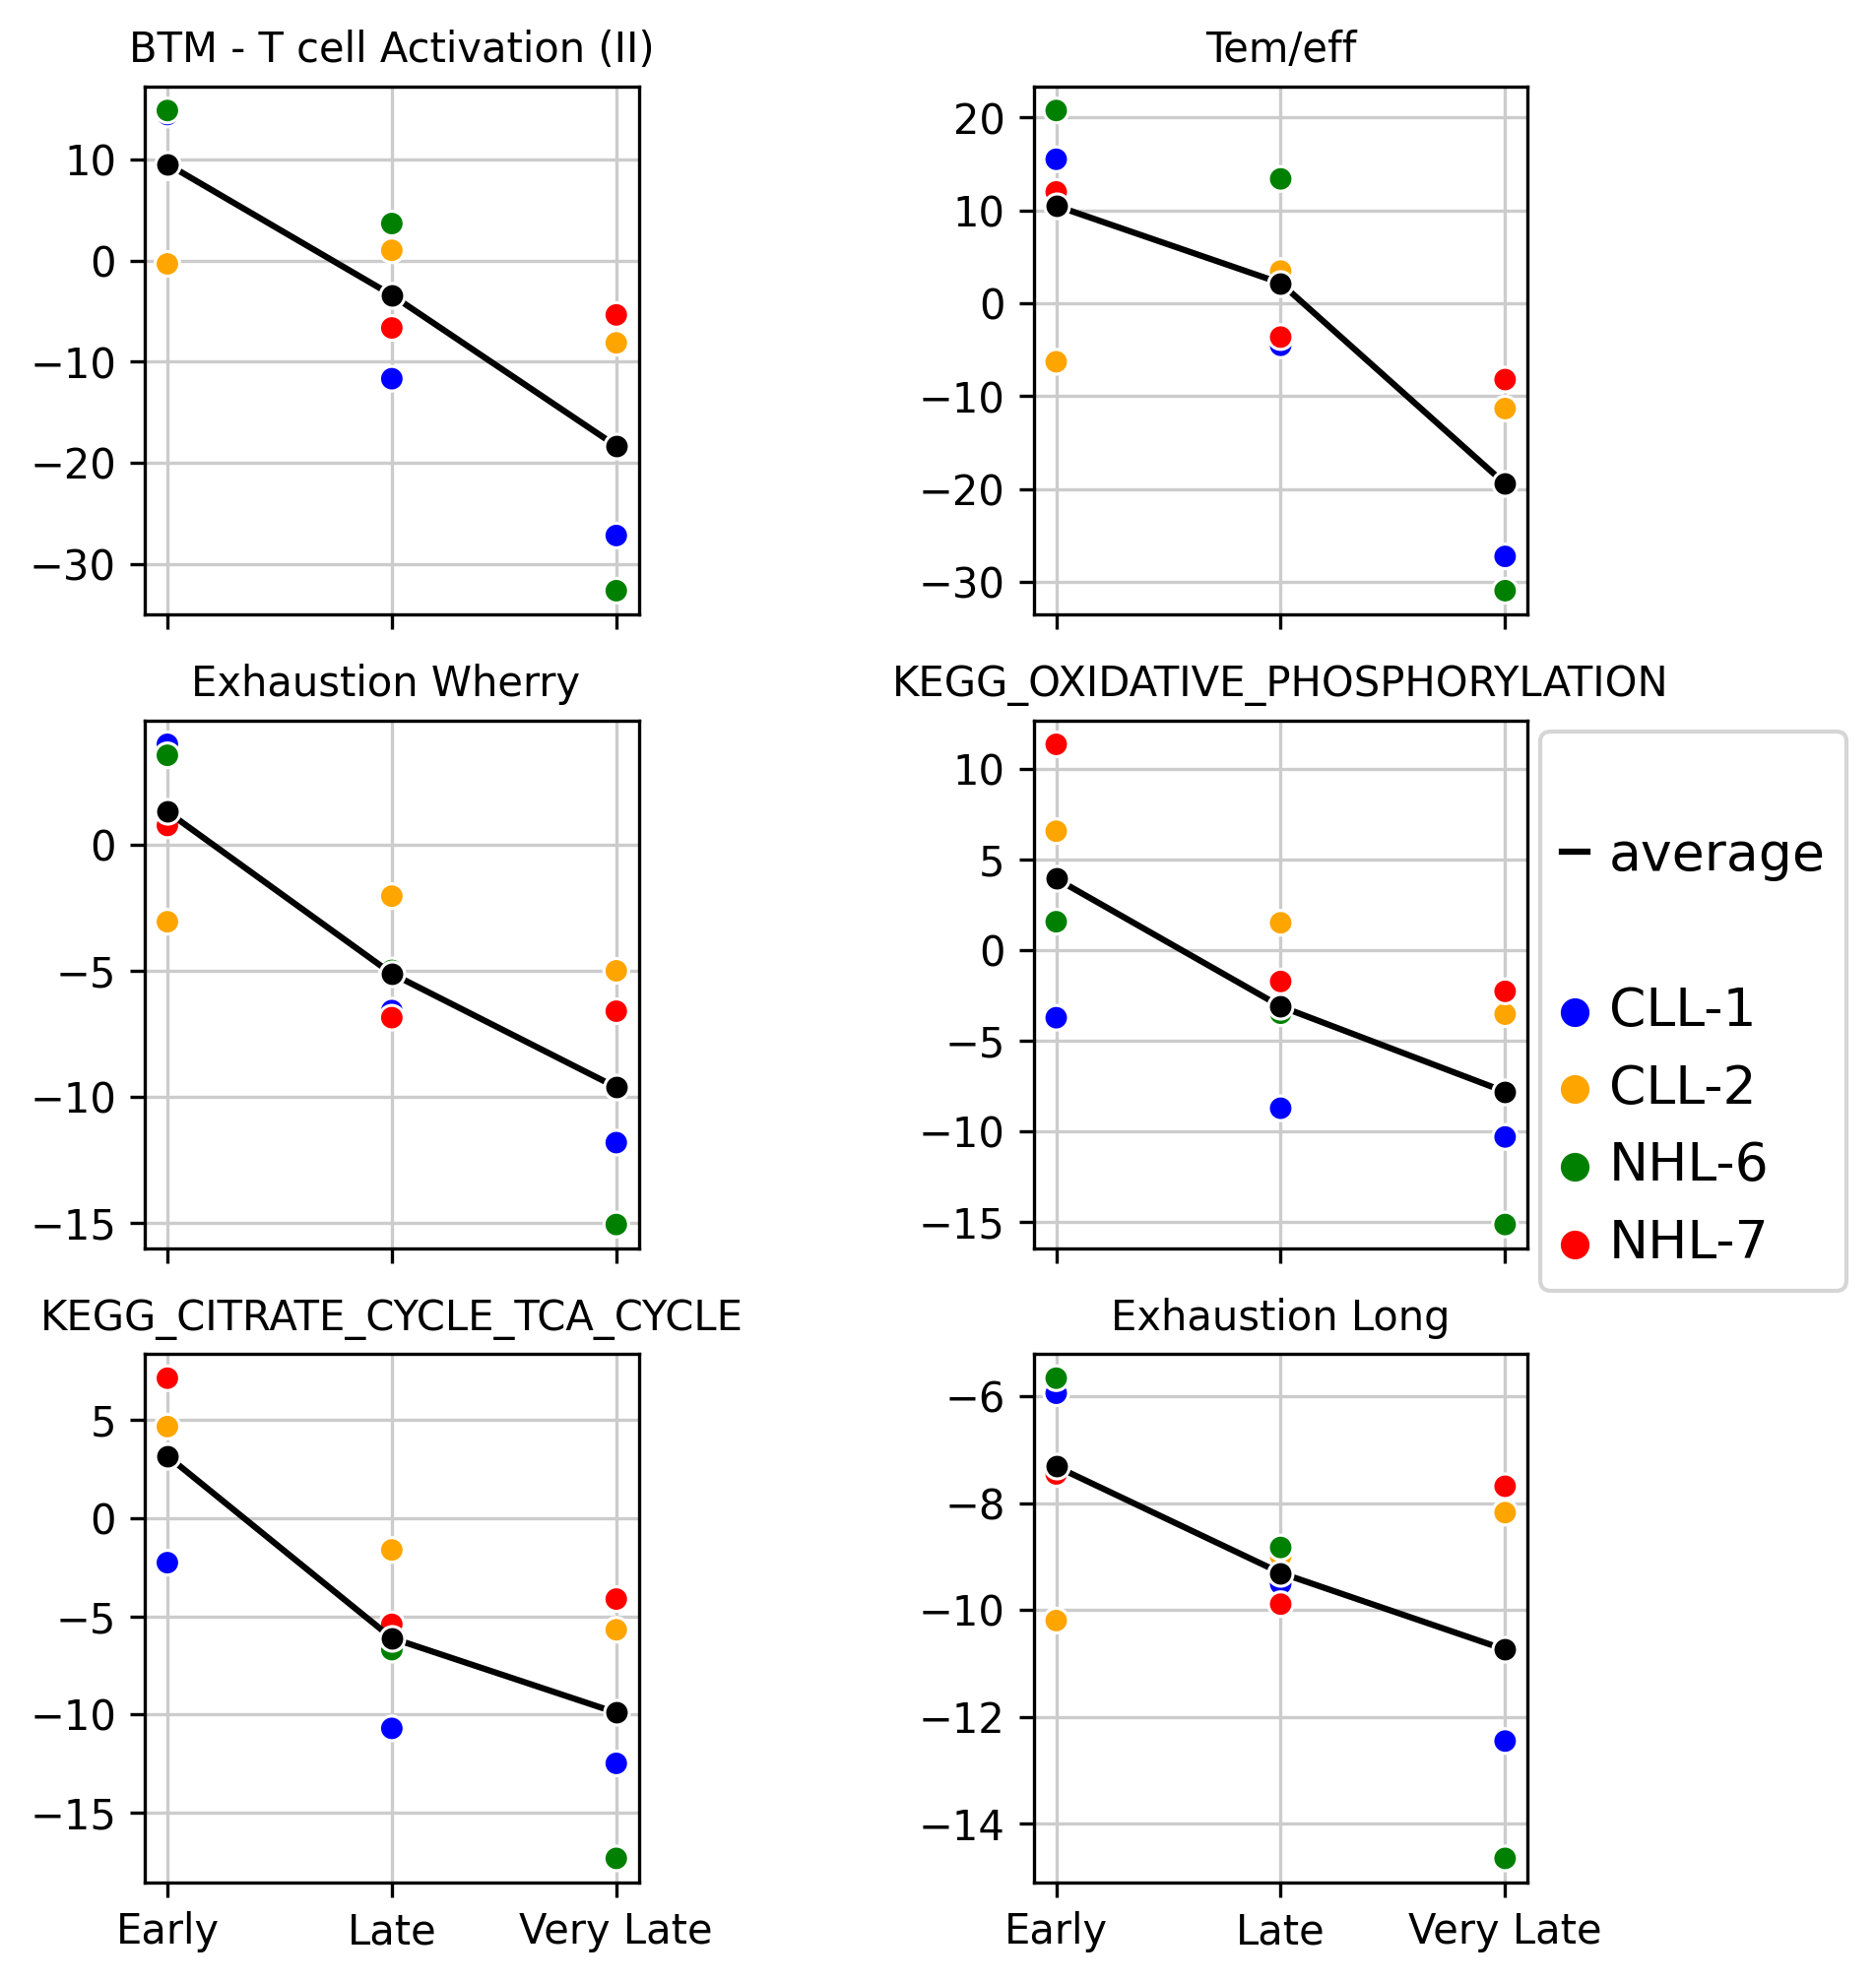

In [ ]:
#Plot the GSEA combined tscores versus time point as a scatter plot with the average overlayed as a line plot. 

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(3,2, sharex=True)
fig.set_size_inches(6, 8)
plt.subplots_adjust(wspace=0.8)


n=0
k=0
for x in data.gsea.unique():
  sns.scatterplot(x='group', y='tscore',hue='patient', data=data[(data.gsea == x) & (data.patient != 'average')], 
                  ci=None, marker='o', ax=ax[n,k], palette=['blue', 'orange', 'green', 'red']
                  )
  sns.lineplot(x='group', y='tscore',hue='patient', data=data[(data.gsea == x) & (data.patient == 'average')],
               ci=None, marker='o', ax=ax[n,k], palette=['black']
               )
  ax[n,k].get_legend().remove()
  ax[n,k].tick_params(axis='x', labelsize=10) 
  ax[n,k].tick_params(axis='y', labelsize=10) 
  ax[n,k].set(title=x)
  ax[n,k].title.set_size(10)
  ax[n,k].yaxis.set_zorder(0)
  ax[n,k].xaxis.set_zorder(0)
  ax[n,k].set(ylabel='')
  ax[n,k].set(xlabel='')

  n+=1
  k+=1
  if k == 2:
    k=0
  if n == 3:
    n=0

legend = ax[1,1].legend(bbox_to_anchor=(1.7,.45),loc="right")
legend.texts[0].set_text('')
legend.texts[2].set_text('')

In [ ]:
#Panel D - MKI67
#a list of the patient name, the patient group, and the log transformed expression data for MKI67
list_1 = ge.obs['patient']
list_2 = ge.obs['group']
list_3 = ge[:,'MKI67'].X[:,0]

#create a DataFrame with each of these lists as a column
mki67 = pd.DataFrame(zip(list_1,list_2, list_3), columns=['patient', 'group', 'MKI67'])

[Text(0, 0.5, 'Normalized gene expression')]

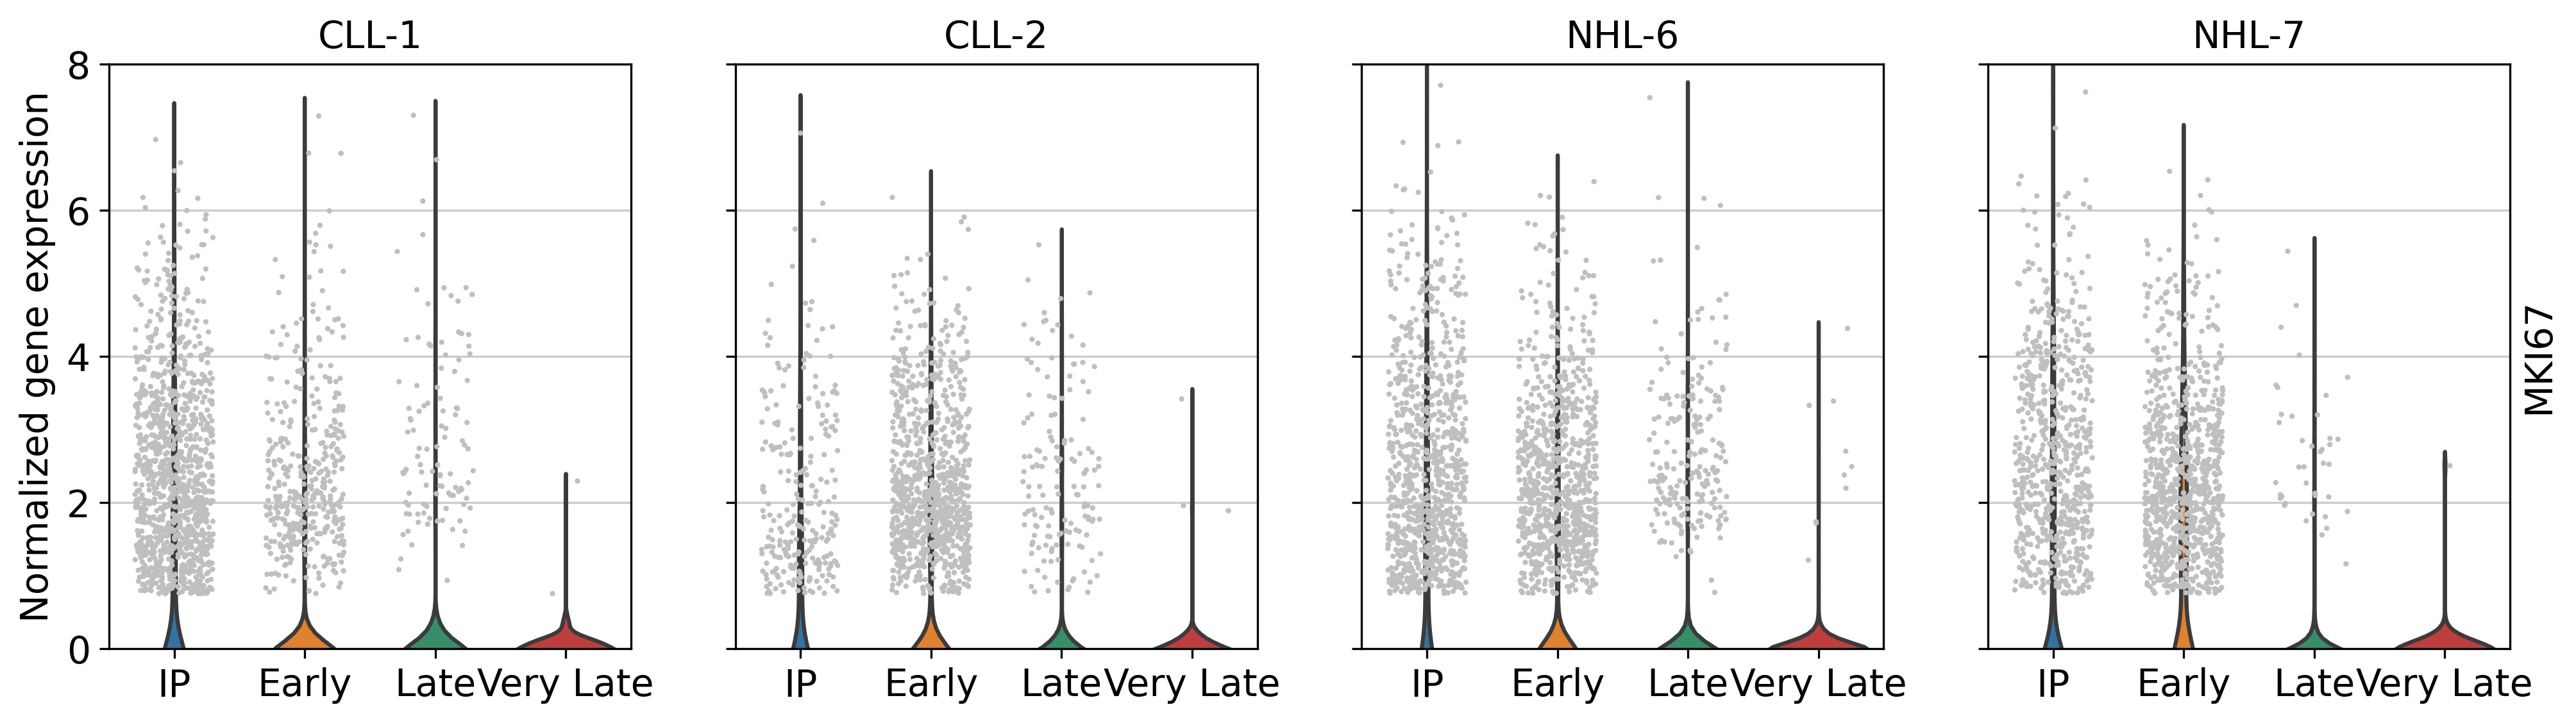

In [ ]:
#For Fig 5 Panel D
#Plot a Violin plot and strip plot for each of the patients at each timepoint to show expression changes in MKI67
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1,4)
fig.set_size_inches(16, 4)

#set an iterator
n=0
#Create a subplot for each patient, correct the order to IP, Early, Late, V Late, and also truncate the stripplot to only show expression above 0.75 
for x in ['CLL-1', 'CLL-2', 'NHL-6', 'NHL-7']:
  sns.violinplot(x='group', y='MKI67',data=mki67[mki67['patient']==x], inner=None, ax=ax[n], 
                 order=('IP', 'Early', 'Late', 'Very Late')
                 )
  sns.stripplot(x='group', y='MKI67',data=mki67[(mki67['patient']==x) & (mki67['MKI67'] >0.75)], 
                color='0.75', size=2, jitter=0.3, ax=ax[n], order=('IP', 'Early', 'Late', 'Very Late')
                )
  ax[n].set(ylim=(0,8))
  ax[n].set(xlabel= '')
  ax[n].set_title(str(x))
  ax[n].yaxis.set_zorder(0)
  if n > 0:
    ax[n].yaxis.set_ticklabels([])
    ax[n].set(ylabel='')
  if n == 3:
    ax[n].set(ylabel='MKI67')
    ax[n].yaxis.set_label_position('right')
  n+=1
  
ax[0].set(ylabel='Normalized gene expression')


In [ ]:
#For panel E 
#import data from the supplemental file, supplemental file has been reformatted for best DataFrame structure
fig_5_e_file = DATA / 'Supplemental data.xlsx'
inhib = pd.read_excel(fig_5_e_file, sheet_name='Figure 5e')

Text(0.57, 0.0, '# of co-inhibitory receptors')

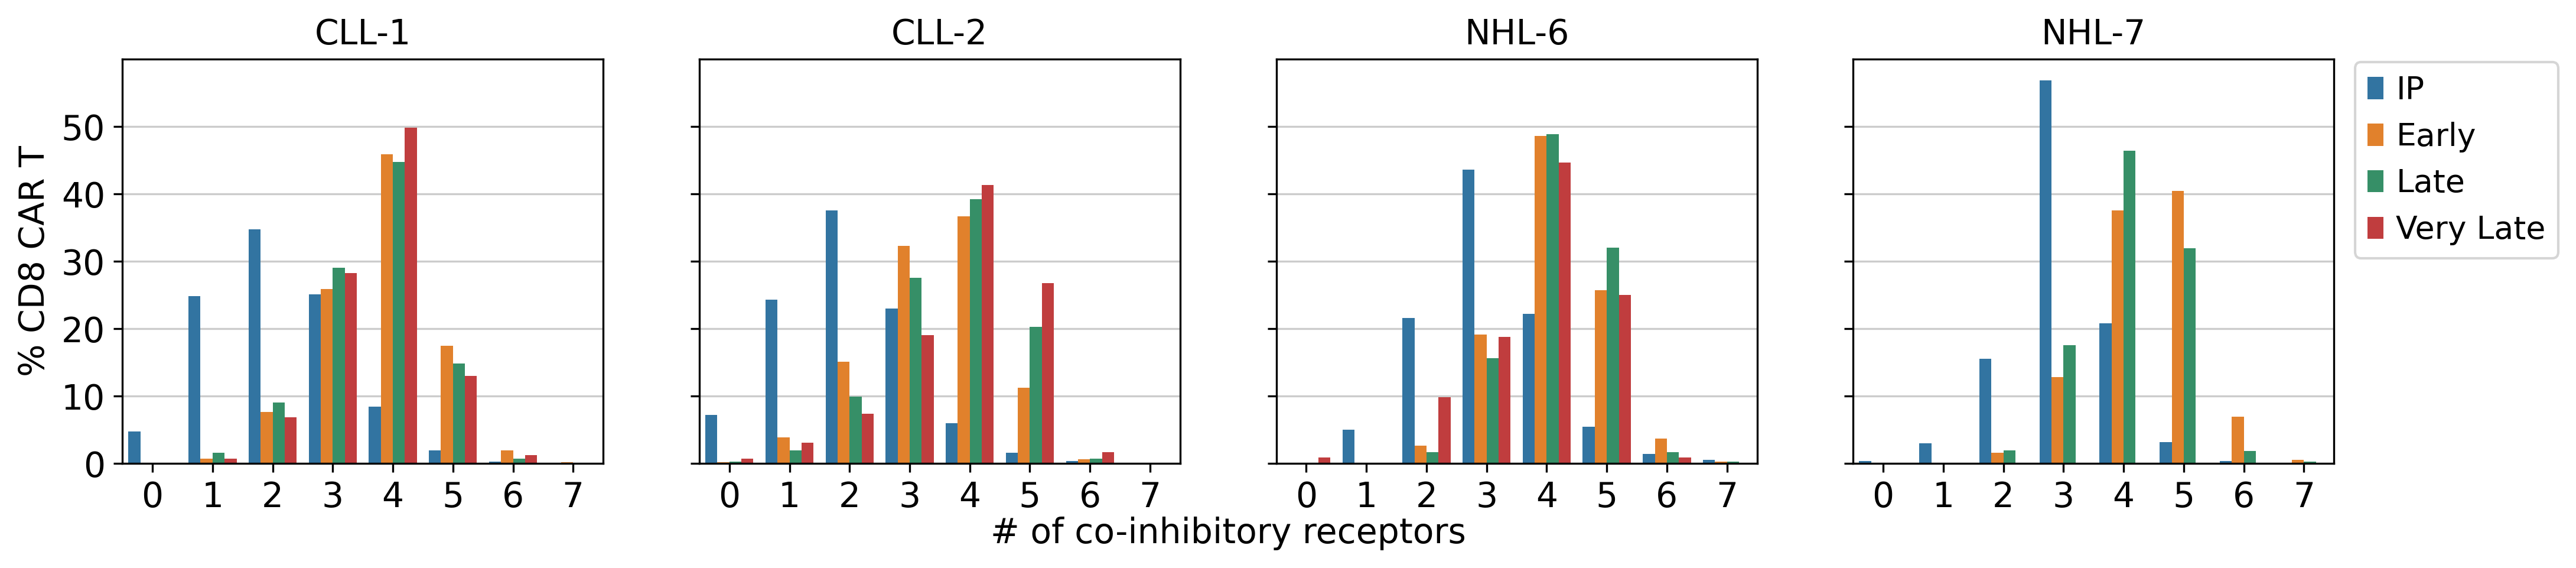

In [ ]:
#Graph barcharts across the samples for the number of co-inhibitory receptors at each time point
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax = plt.subplots(1,4, sharex=True, sharey=True)
fig.set_size_inches(16, 3)

n=0
for x in inhib.Patient.unique():
  sns.barplot(x="# of inhibitory receptors", y="% CD8 CAR T", hue="Group", data=inhib[inhib['Patient']==x], 
              ax=ax[n]
              )
  ax[n].set(title=x)
  #formatting of the image below
  if n<3:
    ax[n].get_legend().remove()
  ax[n].set_ylim([0,60])
  ax[n].yaxis.set_ticks([0,10,20,30,40,50])
  ax[n].yaxis.set_zorder(0)
  ax[n].set(xlabel='')
  if n > 0:
    ax[n].set(ylabel='')
  n+=1

#more formatting
ax[3].legend(bbox_to_anchor=(1.5,.75),loc="right")
fig.text(0.57, 0.0, '# of co-inhibitory receptors', ha='center')